In [1]:
import pandas as pd
import numpy as np
from os.path import join
import itertools
from scipy import stats
import os
import math
import random
from util_val import *
import glob
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

In [2]:
os. getcwd() 
RESULT_DIR =join('./','results/validation949_x')
df_design = pd.read_csv('data/designMatrix.csv',index_col=0)
df_nicolas = pd.read_csv('data/Nicolas.csv',index_col=0)



'/Users/huangyiming/ProjectWorkspace/TLCB'

In [ ]:
# PanelName = []
# ConditionName = []
# Fscore = []
# Delta = []
# Ustatistic = []
# Upvalue = []


# panel_sizes= df_measurements['size']
# for panelID in range(1,950):
#     size = panel_sizes[panelID-1]
#     for filepath in glob.glob(RESULT_DIR+'/panel'+str(panelID)+'/*_metrics.csv'):
#         pathlist = os.path.normpath(filepath).split(os.path.sep)
#         PanelName.append(pathlist[2])
#         conditionname = pathlist[3].split('_')[0]
#         ConditionName.append(conditionname)
#         metrics = pd.read_csv(filepath,index_col=0) 
#         metrics_fscore = metrics['fscore']
#         Fscore.append(np.mean(metrics_fscore))
        
#         metrics_fscore_random = df_RandPool[conditionname+'_size'+str(size)]
#         delta, level = cliffs_delta(metrics_fscore,metrics_fscore_random) #x1-x2
#         Delta.append(delta)
#         ustatistic, upvalue = stats.mannwhitneyu(metrics_fscore,metrics_fscore_random,alternative='greater')
#         Ustatistic.append(ustatistic)
#         Upvalue.append(upvalue)

# df_Summary= pd.DataFrame({'PanelName':PanelName,'ConditionName':ConditionName,'Fscore':Fscore,'Delta':Delta,'Ustatistic':Ustatistic,'Upvalue':Upvalue})
# df_Summary.set_index('PanelName', inplace=True)


# df_Summary

# PanelName = ['panel'+str(i) for i in range(1,950)]
# validation_fscore = df_Summary.pivot(columns='ConditionName',values='Fscore')
# validation_fscore = validation_fscore.loc[PanelName]
# validation_fscore.to_csv('./y_validation_fscore.csv')
# validation_delta = df_Summary.pivot(columns='ConditionName',values='Delta')
# validation_delta = validation_delta.loc[PanelName]
# validation_delta.to_csv('./y_validation_delta.csv')
# validation_u = df_Summary.pivot(columns='ConditionName',values='Ustatistic')
# validation_u = validation_u.loc[PanelName]
# validation_u.to_csv('./y_validation_u.csv')

PanelName = []
ConditionName = []
Fscore = []

panel_sizes= df_measurements['size']
for panelID in range(1,950):
    size = panel_sizes[panelID-1]
    for filepath in glob.glob('results/validation949_x/panel'+str(panelID)+'/*_metrics.csv'):
        pathlist = os.path.normpath(filepath).split(os.path.sep)
        
        conditionname = pathlist[3].split('_')[0]
        if (conditionname in  df_design.columns):
            ConditionName.append(conditionname)
            PanelName.append(pathlist[2])
            metrics = pd.read_csv(filepath,index_col=0) 
            metrics_fscore = metrics['fscore']
            Fscore.append(np.mean(metrics_fscore))
        

df_Summary= pd.DataFrame({'PanelName':PanelName,'ConditionName':ConditionName,'Fscore':Fscore})
df_Summary.set_index('PanelName', inplace=True)

PanelName = ['panel'+str(i) for i in range(1,950)]
validation_fscore = df_Summary.pivot(columns='ConditionName',values='Fscore')
validation_fscore = validation_fscore.loc[PanelName]
validation_fscore.to_csv('./x_c13.csv')
validation_fscore.max(axis=0)

In [ ]:

PanelName = []
ConditionName = []
Fscore = []

# panel_sizes= df_measurements['size']
for panelID in range(1,950):
#     size = panel_sizes[panelID-1]
    for filepath in glob.glob('results/validation949_y/panel'+str(panelID)+'/*_statistic.csv'):
        pathlist = os.path.normpath(filepath).split(os.path.sep)
        
        conditionname = pathlist[3].split('_')[0]

        ConditionName.append(conditionname)
        PanelName.append(pathlist[2])
        metrics = pd.read_csv(filepath,index_col=0) 
        metrics_statistic = pd.read_csv(filepath,index_col=0) 
        Fscore.append(metrics_statistic.loc['fscore','mean'])
        

df_Summary= pd.DataFrame({'PanelName':PanelName,'ConditionName':ConditionName,'Fscore':Fscore})
df_Summary.set_index('PanelName', inplace=True)

PanelName = ['panel'+str(i) for i in range(1,950)]
validation_fscore = df_Summary.pivot(columns='ConditionName',values='Fscore')
validation_fscore = validation_fscore.loc[PanelName]
validation_fscore.to_csv('./y_c10.csv')
validation_fscore.max(axis=0)


PanelName = []
ConditionName = []
Fscore = []

# panel_sizes= df_measurements['size']
for panelID in range(1,950):
#     size = panel_sizes[panelID-1]
    for filepath in glob.glob('results/validation949_y_random/panel'+str(panelID)+'/*_statistic.csv'):
        pathlist = os.path.normpath(filepath).split(os.path.sep)
        
        conditionname = pathlist[3].split('_')[0]
        ConditionName.append(conditionname)
        PanelName.append(pathlist[2])
        metrics_statistic = pd.read_csv(filepath,index_col=0) 
        Fscore.append(metrics_statistic.loc['fscore','mean'])
        

df_Summary= pd.DataFrame({'PanelName':PanelName,'ConditionName':ConditionName,'Fscore':Fscore})
df_Summary.set_index('PanelName', inplace=True)

PanelName = ['panel'+str(i) for i in range(1,950)]
validation_fscore_random = df_Summary.pivot(columns='ConditionName',values='Fscore')
validation_fscore_random = validation_fscore_random.loc[PanelName]
validation_fscore_random.to_csv('./y_c10_random.csv')
validation_fscore_random.max(axis=0)

In [ ]:
pd.DataFrame({'biomarkers mean':validation_fscore.mean(axis=0),'random panel mean':validation_fscore_random.mean(axis=0)})

In [3]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from numpy.polynomial.polynomial import polyfit

scaler = StandardScaler()
df_x = pd.read_csv('./X_m9.csv',index_col=0)
X = df_x.to_numpy()
X = scaler.fit_transform(X)
metric_names = pd.read_csv('./X_m9.csv',index_col=0).columns.to_numpy()   
y = pd.read_csv('./X_c13.csv',index_col=0).to_numpy()
y = np.mean(y,axis=1)

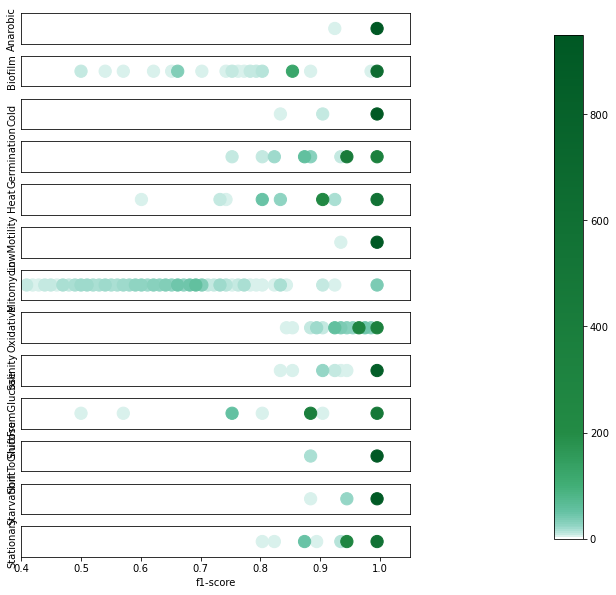

In [273]:
import matplotlib.cm as cm
import matplotlib.colors as col
y = pd.read_csv('./X_c13.csv',index_col=0)
y_mean = np.mean(y.to_numpy(),axis=1)

f,a = plt.subplots(13,1,figsize=(8,10))
# f.tight_layout() 
a = a.ravel()
y_labs = y.columns

cvals  = [0,5,20,50,100,200,949]
colors = ["#ffffff","#ccece6","#99d8c9","#66c2a4","#41ae76","#238b45","#005824"]

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = col.LinearSegmentedColormap.from_list("", tuples)
for idx,ax in enumerate(a):
    full_f1s = y.iloc[:,idx]


    bins = np.linspace(0, 1, 100)
    #weightsa = np.ones_like(full_f1s)/float(len(full_f1s))
    hist, bin_edges=np.histogram(np.array(full_f1s), bins) 
    
    # Sort the points by density, so that the densest points are plotted last
#     x = np.random.normal(size=len(hist))
    y_values = np.zeros(len(hist))
    x_values = np.array([(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)])
    re_idx = hist.argsort()
    
    im = ax.scatter(x_values[re_idx], y_values[re_idx], c=hist[re_idx],cmap=cmap, norm=norm,s=150)
 
    _ = ax.set_ylabel('')
    _ = ax.set_yticks([])
    if idx<12:
        _ = ax.set_xticks([])
        _ = ax.set_xlabel('')
    else:
        _ = ax.set_xlabel('f1-score')
    _ = ax.set_ylabel(y_labs[idx])
    _ = ax.set_xlim(0.4, 1.05)

    
    
f.subplots_adjust(right=0.8,wspace=0.05, hspace=0.4)
cbar_ax = f.add_axes([1.05, 0.15, 0.05, 0.7])
f.colorbar(im, cax=cbar_ax)

plt.savefig('./figures/scatterhist_traindata.pdf', bbox_inches='tight')




In [4]:
# alpha here is lambda in some elasticnet equation, and l1_ratio is alpha
l1_ratio_list = [1e-4,1e-3,1e-2,0.1,0.3,0.5,0.7,0.9]
alphas_list = np.linspace(0.1, 1, 10)
regr = ElasticNetCV(cv=10,alphas=alphas_list,l1_ratio=l1_ratio_list,n_jobs=4,random_state=0)
regr.fit(X, y)
print('coefficients:',regr.coef_)
print('intercept:',regr.intercept_)
print('optimal alpha:',regr.alpha_)
print('optimal L1 ration:',regr.l1_ratio_)

ElasticNetCV(alphas=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
             cv=10, l1_ratio=[0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9],
             n_jobs=4, random_state=0)

coefficients: [ 0.00308195 -0.00296231  0.00124422  0.00038554  0.00474563 -0.00059125
 -0.00088916  0.00196042  0.00039604]
intercept: 0.94565428627376
optimal alpha: 0.2
optimal L1 ration: 0.0001


<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

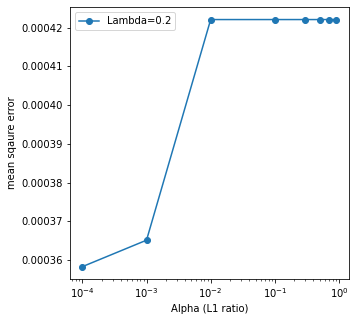

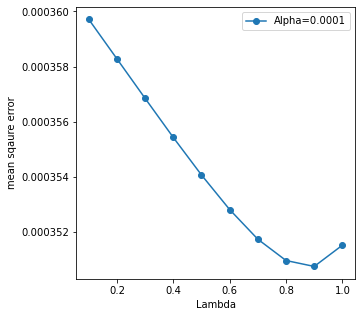

In [310]:
plt.figure(figsize = (5,5))
msePerLamda = np.mean(regr.mse_path_,axis=2)[:,alphas_list==regr.alpha_].flatten() 
_ = plt.plot(l1_ratio_list,msePerLamda,'-o',label='Lambda={}'.format(regr.alpha_))
_ = plt.legend()
_ = plt.xlabel('Alpha (L1 ratio)')
ax = plt.gca()
_ = ax.set_xscale('log')
_ = plt.ylabel('mean sqaure error')
_ = plt.savefig('figures/AlphaTune.pdf')
plt.figure(figsize = (5,5))
msePerAlpha= np.mean(regr.mse_path_,axis=2)[l1_ratio_list==regr.l1_ratio_,:].flatten()
_ = plt.plot(alphas_list,msePerAlpha,'-o',label='Alpha={}'.format(regr.l1_ratio_))
_ = plt.legend()
_ = plt.xlabel('Lambda')
_ = plt.ylabel('mean sqaure error')
_ = plt.savefig('figures/LambdaTune.pdf')

<Figure size 360x360 with 0 Axes>

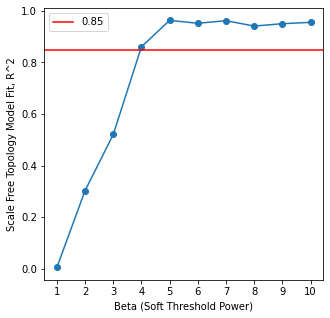

In [311]:
cen_beta = np.array([1,2,3,4,5,6,7,8,9,10])
scalefree_rsquare = np.array([0.004842158, 0.302883742, 0.520641319, 0.860661165, 0.963415606, 0.952029385, 0.962113511, 0.941271935, 0.950390257, 0.955688480])
plt.figure(figsize = (5,5))
_ = plt.plot(cen_beta,scalefree_rsquare,'-o')


_ = plt.xlabel('Beta (Soft Threshold Power)')
_ = plt.ylabel('Scale Free Topology Model Fit, R^2')
_ = plt.axhline(0.85,color='red', label='0.85')
_ = plt.xticks(cen_beta, cen_beta)
_ = plt.legend()

_ = plt.savefig('figures/BetaTune.pdf')

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

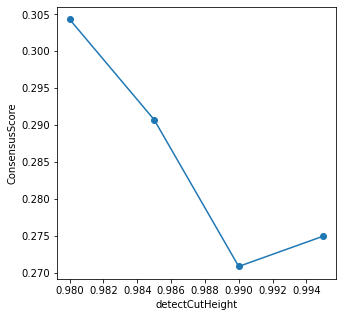

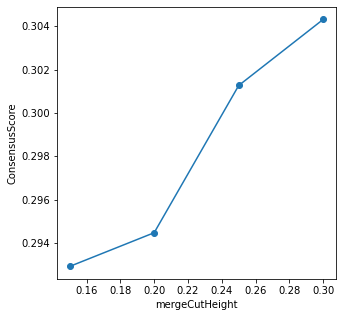

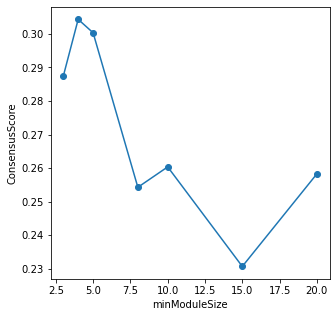

In [312]:
# "Best consensus ccore=0.304319707548929 achieved when detectCutHeight=0.98 mergeCutHeight_=0.3 minModuleSize=4"

df_modIdTune=pd.read_csv('results/modIdTune_summary.csv',index_col=0)

Idx_mask=np.logical_and(df_modIdTune['mergeCutHeight']==0.3, df_modIdTune['minModuleSize']==4)
plt.figure(figsize = (5,5))
_ = plt.plot(df_modIdTune.loc[Idx_mask]['detectCutHeight'],df_modIdTune.loc[Idx_mask]['ConsensusScore'],'-o')
_ = plt.xlabel('detectCutHeight')
_ = plt.ylabel('ConsensusScore')
_ = plt.savefig('figures/detectCutHeight_Tune.pdf')

Idx_mask=np.logical_and(df_modIdTune['detectCutHeight']==0.98, df_modIdTune['minModuleSize']==4)
plt.figure(figsize = (5,5))
_ = plt.plot(df_modIdTune.loc[Idx_mask]['mergeCutHeight'],df_modIdTune.loc[Idx_mask]['ConsensusScore'],'-o')
_ = plt.xlabel('mergeCutHeight')
_ = plt.ylabel('ConsensusScore')
_ = plt.savefig('figures/mergeCutHeight_Tune.pdf')

Idx_mask=np.logical_and(df_modIdTune['detectCutHeight']==0.98, df_modIdTune['mergeCutHeight']==0.3)

plt.figure(figsize = (5,5))
_ = plt.plot(df_modIdTune.loc[Idx_mask]['minModuleSize'],df_modIdTune.loc[Idx_mask]['ConsensusScore'],'-o')
_ = plt.xlabel('minModuleSize')
_ = plt.ylabel('ConsensusScore')
_ = plt.savefig('figures/minModuleSize_Tune.pdf')


In [302]:
Idx_mask

1      False
2      False
3      False
4      False
5      False
       ...  
108    False
109    False
110    False
111    False
112    False
Length: 112, dtype: bool

ElasticNet(alpha=0.2, l1_ratio=0.0001)

ElasticNet(alpha=0.2, l1_ratio=0.0001)

ElasticNet(alpha=0.2, l1_ratio=0.0001)

ElasticNet(alpha=0.2, l1_ratio=0.0001)

ElasticNet(alpha=0.2, l1_ratio=0.0001)

ElasticNet(alpha=0.2, l1_ratio=0.0001)

ElasticNet(alpha=0.2, l1_ratio=0.0001)

ElasticNet(alpha=0.2, l1_ratio=0.0001)

ElasticNet(alpha=0.2, l1_ratio=0.0001)

ElasticNet(alpha=0.2, l1_ratio=0.0001)

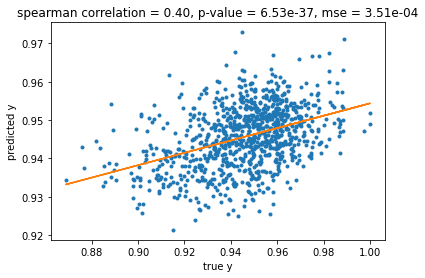

In [7]:
#from numpy.polynomial.polynomial import polyfit

kf=KFold(n_splits=10, random_state=None, shuffle=False)
y_hat_folds = np.zeros(len(y))

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regr_fold = ElasticNet(alpha=regr.alpha_,l1_ratio=regr.l1_ratio_)
    regr_fold.fit(X_train, y_train)

    y_hat_folds[test_index] = regr_fold.predict(X_test)
#     regr_fold.score(X_test,y_test)
#     mean_squared_error(y_test,regr_fold.predict(X_test))
    
_ = plt.plot(y,y_hat_folds,'.')
# _ = plt.plot([y.min(), y.max()], [y_hat_folds.min(), y_hat_folds.max()], 'k', lw=1)
b, m = polyfit(y,y_hat_folds, 1)
_ = plt.plot(y, b + m * y, '-')

_ = plt.xlabel('true y')
_ = plt.ylabel('predicted y')
rho, pval = stats.spearmanr(y,y_hat_folds)
mse = mean_squared_error(y,y_hat_folds)

_ = plt.title('spearman correlation = {:.2f}, p-value = {:.2e}, mse = {:.2e}'.format(rho,pval,mse))
_ = plt.show()

ElasticNet(alpha=0.2, l1_ratio=0.0001)

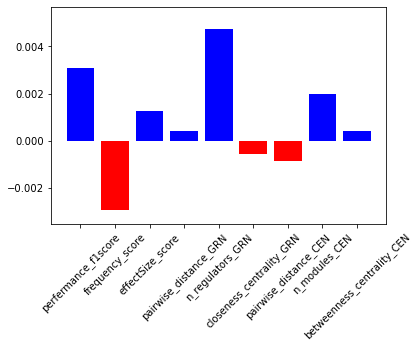

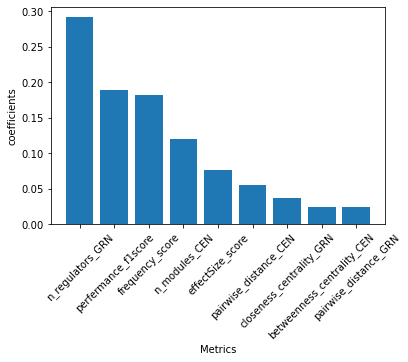

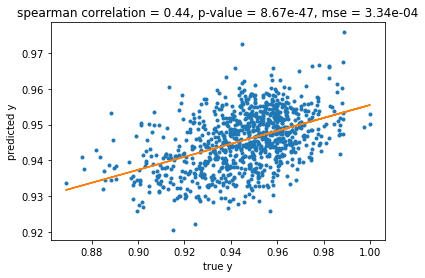

In [8]:
# 
regr_full = ElasticNet(alpha=regr.alpha_,l1_ratio=regr.l1_ratio_)
regr_full.fit(X, y)



_ = plt.bar(metric_names,regr_full.coef_,color=['blue' if weight>0 else 'red' for weight in regr_full.coef_])
_ = plt.ylim([np.min(regr_full.coef_)*1.2,np.max(regr_full.coef_)*1.2])
_ = plt.xticks(rotation=45)
_ =plt.show()
abs_weights= abs(regr_full.coef_)
abs_weights = abs_weights/sum(abs_weights)
idx_sort = np.argsort(abs_weights)[::-1]
_ = plt.bar(metric_names[idx_sort],abs_weights[idx_sort])
_ = plt.xlabel('Metrics')
_ = plt.xticks(rotation=45)
_ = plt.ylabel('coefficients')
_ =plt.show()


_ =plt.savefig('./figures/bar_absWeights.pdf')





y_hat = regr_full.predict(X) #np.sum(X* regr.coef_, axis=1)+regr.intercept_
_ = plt.plot(y,y_hat,'.')
# _ = plt.plot([y.min(), y.max()], [y_hat_folds.min(), y_hat_folds.max()], 'k', lw=1)
b, m = polyfit(y,y_hat, 1)
_ = plt.plot(y, b + m * y, '-')
_ = plt.xlabel('true y')
_ = plt.ylabel('predicted y')
rho, pval = stats.spearmanr(y,y_hat)
mse = mean_squared_error(y,y_hat)
_ = plt.title('spearman correlation = {:.2f}, p-value = {:.2e}, mse = {:.2e}'.format(rho,pval,mse))

_ =plt.savefig('./figures/scatter_model_full.pdf')



In [229]:
idx_sort = np.argsort(abs_weights)[::-1]


regr_full.coef_[idx_sort]

array([ 0.00474563,  0.00308195, -0.00296231,  0.00196042,  0.00124422,
       -0.00088916, -0.00059125,  0.00039604,  0.00038554])

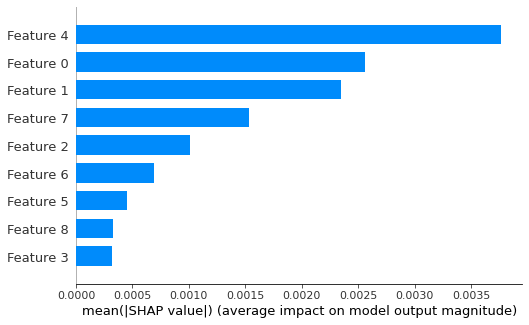

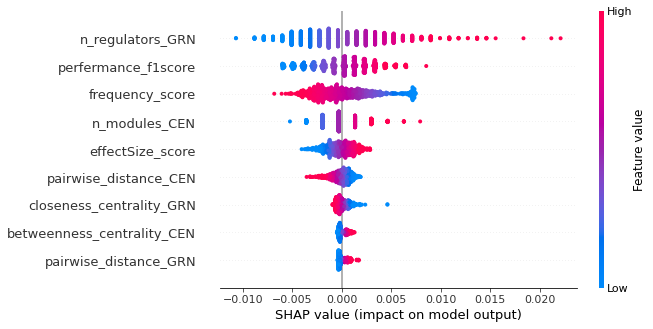

In [9]:
import shap
shap_linear = shap.explainers.Linear(regr_full, X)
shap_values = shap_linear.shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")
f = plt.figure()

shap.summary_plot(shap_values, X,feature_names=metric_names,plot_type='dot')
_ =f.savefig('./figures/shap_model.pdf')



<Figure size 720x432 with 0 Axes>

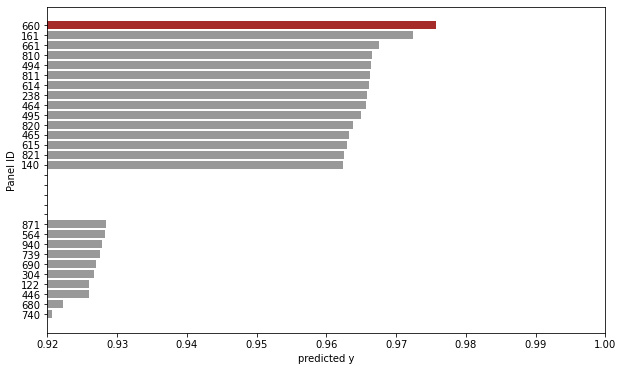

In [10]:
plt.figure(figsize = (10,6))

idx_sort =y_hat.argsort()
widths = np.concatenate([y_hat[idx_sort[:10]],np.empty(5) * np.nan,y_hat[idx_sort[-15:]]])
_ = plt.barh(range(len(widths)),widths,color=['brown' if i==29 else '#999999' for i in range(len(widths))])
_ = plt.xlim([0.92,1.0])
_ = plt.ylabel('Panel ID')
_ = plt.yticks(ticks=range(len(widths)),labels=np.concatenate([[str(x) for x in idx_sort[:10]],np.repeat('',5),[str(x) for x in idx_sort[-15:]]]))
_ = plt.xlabel('predicted y')

plt.savefig('./figures/bar_yhat_rank.pdf')


NameError: name 'y_hat' is not defined

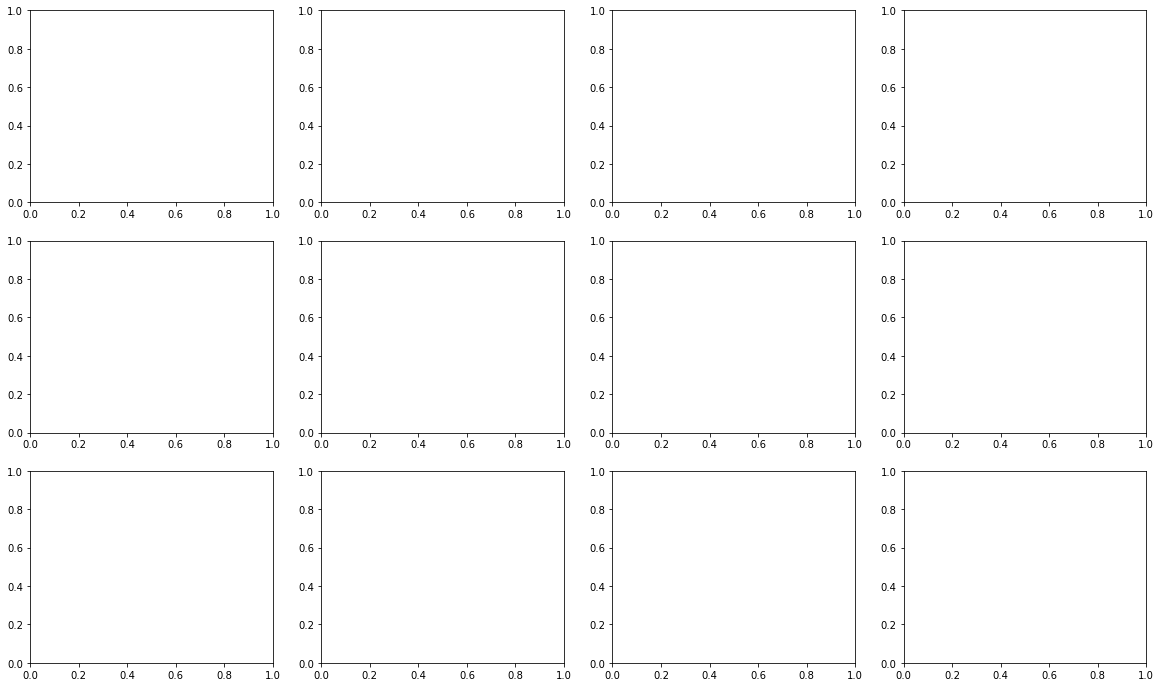

In [4]:
y_ext = pd.read_csv('./y_c10.csv',index_col=0)

f,a = plt.subplots(3,4,figsize=(20,12))
a = a.ravel()
titles = y_ext.columns

for idx,ax in enumerate(a):
    if idx == y_ext.shape[1]:
        break
    full_f1s = y_ext.iloc[:,idx]
    recommend_f1 = y_ext.iloc[np.argmax(y_hat),idx]
    n, bins, patches = ax.hist(full_f1s, 100, density=True, facecolor='g', alpha=0.75)
    _ = ax.set_xlabel('F1-score')
    _ = ax.set_ylabel('Probability')
    _ = ax.set_title(titles[idx])
#     _ = ax.set_text(0.5, 65, 'recommend panel f1-score={}'.format(recommend_f1),color='red')
    _ = ax.set_xlim(0, 1)
    # plt.ylim(0, 0.03)
#     _ = ax.set_grid(True)
    
    _ = ax.axvline(recommend_f1, ymin=0, ymax=plt.gca().get_ylim()[1],color='red', label='recommend panel f1-score={}'.format(recommend_f1))
    _ = ax.legend()
#y_ext.iloc[np.argsort(y_hat)[::-1][:n],]


y_ext_random = pd.read_csv('./y_c10_random.csv',index_col=0)

f,a = plt.subplots(3,4,figsize=(20,16))

a = a.ravel()
titles = y_ext.columns

for idx,ax in enumerate(a):
    if idx == y_ext_random.shape[1]:
        break
    full_f1s = y_ext_random.iloc[:,idx]
    recommend_f1 = y_ext.iloc[np.argmax(y_hat),idx]
    n, bins, patches = ax.hist(full_f1s, 100, density=True, facecolor='g', alpha=0.75)
    _ = ax.set_xlabel('F1-score')
    _ = ax.set_ylabel('Probability')
    _ = ax.set_title(titles[idx])
#     _ = ax.set_text(0.5, 65, 'recommend panel f1-score={}'.format(recommend_f1),color='red')
    _ = ax.set_xlim(0, 1)
    # plt.ylim(0, 0.03)
#     _ = ax.set_grid(True)
    
    _ = ax.axvline(recommend_f1, ymin=0, ymax=plt.gca().get_ylim()[1],color='red', label='recommend panel f1-score={}'.format(recommend_f1))


    _ = ax.legend()



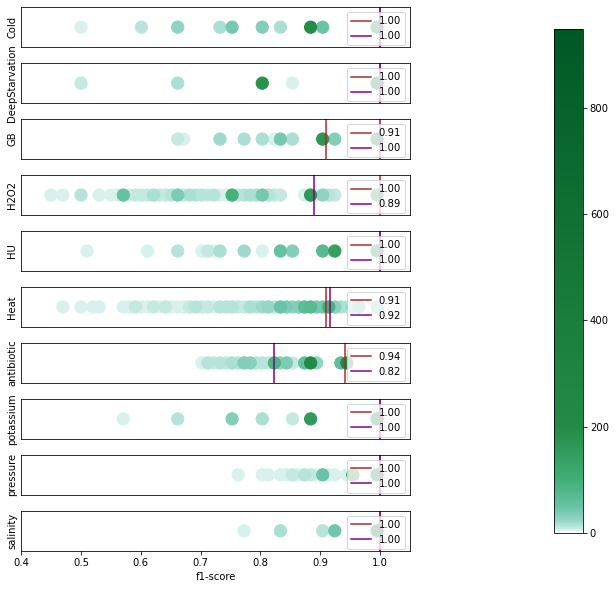

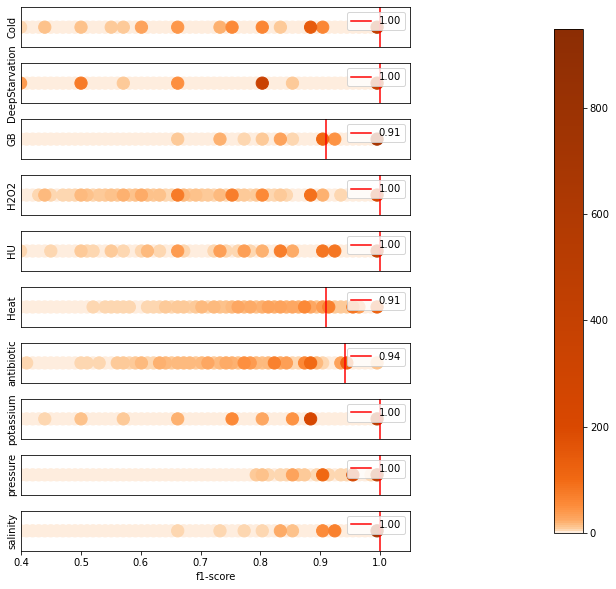

In [19]:
import matplotlib.cm as cm
import matplotlib.colors as col
y_true = pd.read_csv('./X_c13.csv',index_col=0).to_numpy()
y_true = np.mean(y_true,axis=1)

f,a = plt.subplots(10,1,figsize=(8,10))
# f.tight_layout() 
a = a.ravel()
y_labs = y_ext.columns

cvals  = [0,5,20,50,100,200,949]
colors = ["#ffffff","#ccece6","#99d8c9","#66c2a4","#41ae76","#238b45","#005824"]

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = col.LinearSegmentedColormap.from_list("", tuples)
for idx,ax in enumerate(a):
    full_f1s = y_ext.iloc[:,idx]
    recommend_f1 = y_ext.iloc[np.argmax(y_hat),idx]
    TopInternal_f1 = y_ext.iloc[np.argmax(y_true),idx]


    bins = np.linspace(0, 1, 100)
    #weightsa = np.ones_like(full_f1s)/float(len(full_f1s))
    hist, bin_edges=np.histogram(np.array(full_f1s), bins) 
    
    # Sort the points by density, so that the densest points are plotted last
#     x = np.random.normal(size=len(hist))
    y = np.zeros(len(hist))
    x = np.array([(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)])
    re_idx = hist.argsort()
    
    im = ax.scatter(x[re_idx], y[re_idx], c=hist[re_idx],cmap=cmap, norm=norm,s=150)
 
    _ = ax.set_ylabel('')
    _ = ax.set_yticks([])
    if idx<9:
        _ = ax.set_xticks([])
        _ = ax.set_xlabel('')
    else:
        _ = ax.set_xlabel('f1-score')
    _ = ax.set_ylabel(y_labs[idx])
    _ = ax.set_xlim(0.4, 1.05)
    _ = ax.axvline(recommend_f1,color='brown', label='{:.2f}'.format(recommend_f1))
    _ = ax.axvline(TopInternal_f1,color='purple', label='{:.2f}'.format(TopInternal_f1))


    _ = ax.legend()
    
f.subplots_adjust(right=0.8,wspace=0.05, hspace=0.4)
cbar_ax = f.add_axes([1.05, 0.15, 0.05, 0.7])
f.colorbar(im, cax=cbar_ax)

plt.savefig('./figures/scatterhist.pdf', bbox_inches='tight')



f,a = plt.subplots(10,1,figsize=(8,10))
# f.tight_layout() 
a = a.ravel()
y_labs = y_ext_random.columns

cvals  = [0,5,20,50,100,200,949]
colors = ["#feedde","#fdd0a2","#fdae6b","#fd8d3c","#f16913","#d94801","#8c2d04"]

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = col.LinearSegmentedColormap.from_list("", tuples)
for idx,ax in enumerate(a):
    full_f1s = y_ext_random.iloc[:,idx]
    recommend_f1 = y_ext.iloc[np.argmax(y_hat),idx]
    bins = np.linspace(0, 1, 100)
    #weightsa = np.ones_like(full_f1s)/float(len(full_f1s))
    hist, bin_edges=np.histogram(np.array(full_f1s), bins) 
    
    # Sort the points by density, so that the densest points are plotted last
#     x = np.random.normal(size=len(hist))
    y = np.zeros(len(hist))
    x = np.array([(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)])
    re_idx = hist.argsort()
    
    im = ax.scatter(x[re_idx], y[re_idx], c=hist[re_idx],cmap=cmap, norm=norm,s=150)
 
    _ = ax.set_ylabel('')
    _ = ax.set_yticks([])
    if idx<9:
        _ = ax.set_xticks([])
        _ = ax.set_xlabel('')
    else:
        _ = ax.set_xlabel('f1-score')
    _ = ax.set_ylabel(y_labs[idx])
    _ = ax.set_xlim(0.4, 1.05)
    _ = ax.axvline(recommend_f1,color='red', label='{:.2f}'.format(recommend_f1))
    _ = ax.legend()
    
f.subplots_adjust(right=0.8,wspace=0.05, hspace=0.4)
cbar_ax = f.add_axes([1.05, 0.15, 0.05, 0.7])
f.colorbar(im, cax=cbar_ax)

plt.savefig('./figures/scatterhist.pdf', bbox_inches='tight')


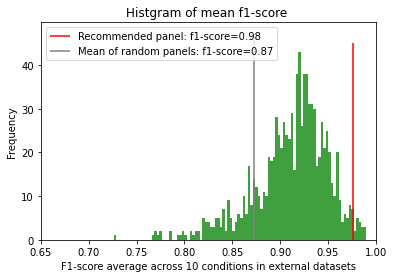

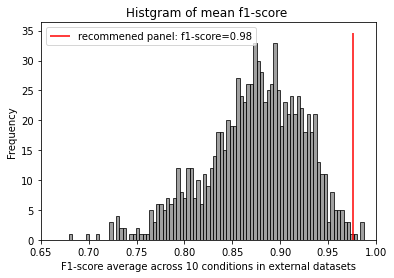

In [12]:
full_f1s = np.mean(y_ext.to_numpy(),axis=1)
recommend_f1 = full_f1s[np.argmax(y_hat)]
y_ext_randomMean = y_ext_random.mean().mean()

_ = plt.figure(0)
n, bins, patches = plt.hist(full_f1s, 100, facecolor='g', alpha=0.75)
_ = plt.xlabel('F1-score average across 10 conditions in external datasets')
_ = plt.ylabel('Frequency')
_ = plt.title('Histgram of mean f1-score ')
_ = plt.xlim(0.65, 1.0)
_ = plt.vlines(recommend_f1, ymin=0, ymax=plt.gca().get_ylim()[1],color='red', label='Recommended panel: f1-score={:.2f}'.format(recommend_f1))

_ = plt.vlines(y_ext_randomMean, ymin=0, ymax=plt.gca().get_ylim()[1],color='grey', label='Mean of random panels: f1-score={:.2f}'.format(y_ext_randomMean))

_ = plt.legend()
plt.savefig('./figures/hist_mean.pdf')


full_f1s = np.mean(y_ext_random.to_numpy(),axis=1)
_ = plt.figure(1)


n, bins, patches = plt.hist(full_f1s, 100, facecolor='g', alpha=0.75,fc = "grey", ec="black")
_ = plt.xlabel('F1-score average across 10 conditions in external datasets')
_ = plt.ylabel('Frequency')
_ = plt.title('Histgram of mean f1-score ')
_ = plt.xlim(0.65, 1.0)
_ = plt.vlines(recommend_f1, ymin=0, ymax=plt.gca().get_ylim()[1],color='red', label='recommened panel: f1-score={:.2f}'.format(recommend_f1))
_ = plt.legend()
plt.savefig('./figures/hist_mean_random.pdf')





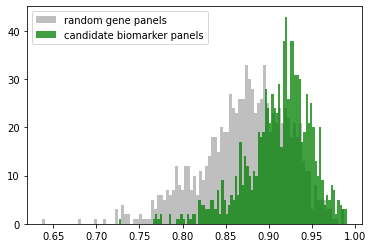

In [3]:
y_ext = pd.read_csv('./y_c10.csv',index_col=0)
y_ext_random = pd.read_csv('./y_c10_random.csv',index_col=0)


full_f1s_random = np.mean(y_ext_random.to_numpy(),axis=1)
n2, bins2, patche2s = plt.hist(full_f1s, 100, facecolor='g', alpha=0.5,fc = "grey", label='random gene panels')

full_f1s = np.mean(y_ext.to_numpy(),axis=1)
n1, bins1, patches1 = plt.hist(full_f1s, 100, facecolor='g', alpha=0.75, label='candidate biomarker panels')

_ = plt.legend()
# plt.savefig('./figures/HistRandomBiomarker.pdf')



In [7]:
recommended_f1 = full_f1s[660]
sum(full_f1s<recommended_f1)/len(full_f1s)
sum(full_f1s_random<recommended_f1)/len(full_f1s_random)

0.9799789251844047

0.9957850368809273

In [319]:
full_f1s = np.mean(y_ext.to_numpy(),axis=1)
recommend_panelIdx = np.argmax(y_hat)
recommend_f1 = full_f1s[recommend_panelIdx]
exceed_perc= sum([x<recommend_f1 for x in full_f1s])/len(full_f1s)
print('recommeneded panel id: ',recommend_panelIdx+1,' average f1 score in external datasets: ',recommend_f1, ' higher than ',exceed_perc*100,' % of the candidate panels')

pd.read_csv('./X_c13.csv',index_col=0).to_numpy()[recommend_panelIdx,:]
# y_true[660]
# y_ext.iloc[660,:]
# full_f1s[660]

recommeneded panel id:  661  average f1 score in external datasets:  0.9759358288770048  higher than  97.99789251844047  % of the candidate panels


array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.96551724, 1.        , 0.88888889,
       1.        , 1.        , 1.        ])

In [320]:
y_ext_randomMean

0.8731725059656202

Panels with top 10 predicted y [660 161 661 810 494 811 614 238 464 495]
Panels with top 10 true y [611 610   0 660 299 300 764 661 616 617]


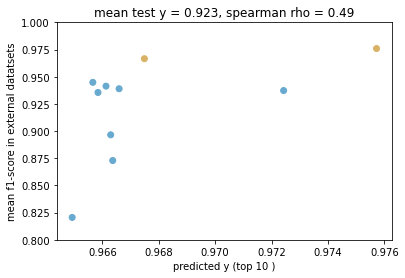

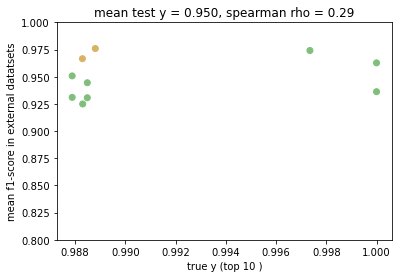

In [112]:
full_f1s = np.mean(y_ext.to_numpy(),axis=1)
n=10

yhat_Ids_topN = np.argsort(y_hat)[::-1][:n]
ytrue_Ids_topN = np.argsort(y_true)[::-1][:n]

_ = plt.figure(0)
print('Panels with top', n, 'predicted y',yhat_Ids_topN) 
Color_list = np.repeat('#67a9cf',n)
Color_list[[x in ytrue_Ids_topN for x in yhat_Ids_topN ]]='#d8b365'
_ = plt.scatter(y_hat[yhat_Ids_topN],full_f1s[yhat_Ids_topN],c=Color_list)
_ = plt.xlabel('predicted y (top '+str(n)+' )')
_ = plt.ylabel('mean f1-score in external datatsets')
_ = plt.ylim([0.8,1])
rho,p = stats.spearmanr(full_f1s[yhat_Ids_topN],y_hat[yhat_Ids_topN])
_ = plt.title('mean test y = {:.3f}, spearman rho = {:.2f}'.format(np.mean(full_f1s[yhat_Ids_topN]),rho))
plt.savefig('./figures/scatter_ytestVSyhat.pdf')

_ = plt.figure(1)
print('Panels with top', n, 'true y',ytrue_Ids_topN)
Color_list = np.repeat('#7fbf7b',n)
Color_list[[x in yhat_Ids_topN for x in ytrue_Ids_topN]]='#d8b365'
_ = plt.scatter(y_true[ytrue_Ids_topN],full_f1s[ytrue_Ids_topN],c=Color_list)
rho,p = stats.spearmanr(full_f1s[ytrue_Ids_topN],y_true[ytrue_Ids_topN])
_ = plt.title('mean test y = {:.3f}, spearman rho = {:.2f}'.format(np.mean(full_f1s[ytrue_Ids_topN]),rho))
_ = plt.xlabel('true y (top '+str(n)+' )')
_ = plt.ylabel('mean f1-score in external datatsets')
_ = plt.ylim([0.8,1])
plt.savefig('./figures/scatter_ytestVSytrue.pdf')





In [145]:
ytest_Ids_topN = np.argsort(full_f1s)[::-1][:n]
ytest_Ids_topN
y_ext.iloc[ytest_Ids_topN,:]

array([695, 696, 366, 255, 365, 699, 901, 194, 536, 253])

,Cold,DeepStarvation,GB,H2O2,HU,Heat,antibiotic,potassium,pressure,salinity
PanelName,,,,,,,,,,
panel696,1.000000,1.0,1.0,1.0,1.000000,0.960000,0.941176,1.0,1.000000,1.0
panel697,1.000000,1.0,1.0,1.0,1.000000,0.960000,0.939191,1.0,1.000000,1.0
panel367,1.000000,1.0,1.0,1.0,1.000000,0.948504,0.941176,1.0,1.000000,1.0
panel256,1.000000,1.0,1.0,1.0,1.000000,0.970800,0.941176,1.0,0.952381,1.0
panel366,1.000000,1.0,1.0,1.0,1.000000,0.919631,0.941176,1.0,1.000000,1.0
panel700,1.000000,1.0,1.0,1.0,1.000000,0.921880,0.937868,1.0,1.000000,1.0
panel902,1.000000,1.0,1.0,1.0,1.000000,0.960000,0.884314,1.0,1.000000,1.0
panel195,1.000000,1.0,1.0,1.0,1.000000,0.944862,0.936544,1.0,0.952381,1.0
panel537,0.888889,1.0,1.0,1.0,1.000000,1.000000,0.941176,1.0,1.000000,1.0


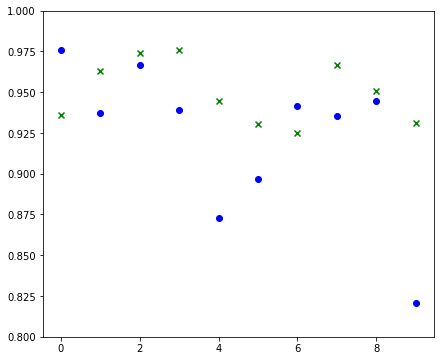

In [178]:
Color_list=np.concatenate([np.repeat('#7fbf7b',10),np.repeat('#d8b365',10)])
Type_list=np.concatenate([np.repeat('o',10),np.repeat('x',10)])


_ = plt.figure(figsize = (7, 6))
_ = plt.scatter(range(10),full_f1s[yhat_Ids_topN],marker='o',c='blue')
_ = plt.scatter(range(10),full_f1s[ytrue_Ids_topN],marker='x',c='green')
_ = plt.ylim([0.8,1])
plt.savefig('./figures/scatter_ypredictedVSytrue.pdf')



#plt.scatter(np.concatenate([range(10),range(10)]),np.concatenate([full_f1s[yhat_Ids_topN],full_f1s[ytrue_Ids_topN]]),marker=Type_list,c=Color_list)

array([707, 680, 780,  36, 161, 863, 266, 485, 437])

array([0.92123412, 0.87016035, 0.96868687, 0.86355562, 0.93727661,
       0.89825998, 0.87672546, 0.96624463, 0.82125137])

array([ 19,  18, 569, 863,  36,  36, 783, 829, 467])

array([0.85477428, 0.84144502, 0.93223716, 0.89825998, 0.86355562,
       0.86355562, 0.91671532, 0.90360958, 0.89668703])

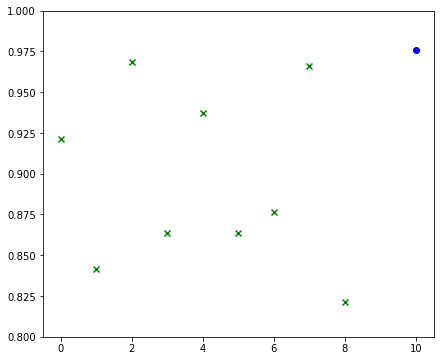

In [179]:
### metric_names
maxFeature_Ids_top = np.argmax(X,axis=0)
minFeature_Ids_top = np.argmin(X,axis=0)
maxFeature_Ids_top
full_f1s[maxFeature_Ids_top]
minFeature_Ids_top
full_f1s[minFeature_Ids_top]

temp_y = [0.92123412, 0.84144502, 0.96868687, 0.86355562, 0.93727661,0.86355562, 0.87672546, 0.96624463, 0.82125137]
_ = plt.figure(figsize = (7, 6))
_ = plt.scatter(range(9),temp_y,marker='x',c='green')
_ = plt.scatter(10,0.976,marker='o',c='blue')
_ = plt.ylim([0.8,1])
plt.savefig('./figures/scatter_individualVSmultiple.pdf')

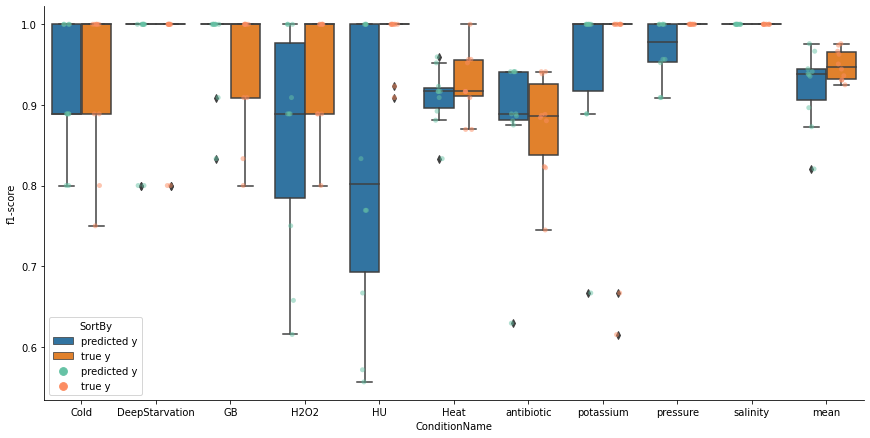

In [88]:
df_topPan = pd.concat([y_ext.iloc[yhat_Ids_topN].reset_index(),y_ext.iloc[ytrue_Ids_topN].reset_index()],axis=0) 
df_topPan ['mean'] = df_topPan.mean(axis=1)
df_topPan = df_topPan.iloc[:,1:12].stack().reset_index().iloc[:,1:3]
df_topPan.columns = ['ConditionName','f1-score']
df_topPan ['SortBy']= np.concatenate([np.repeat('predicted y',110),np.repeat('true y',110)],axis=0)
df_topPan ['PanelIndex']=  np.concatenate([np.repeat(yhat_Ids_topN, 11),np.repeat(ytrue_Ids_topN, 11)],axis=0)
# df_topPan
grped_bplot = sns.catplot(x='ConditionName', y='f1-score', hue='SortBy',data=df_topPan,kind="box",legend=False, height=6, aspect=2)
 
# Add jitter with the swarmplot function
grped_bplot = sns.stripplot(x='ConditionName', 
                            y='f1-score', 
                            hue='SortBy',
                            jitter=True,
                            dodge=True, 
                            marker='o', 
                            palette="Set2",
                            alpha=0.5,
                            data=df_topPan)
plt.savefig('./figures/bar_hatVStrue.pdf')

In [76]:
df_topPan

,ConditionName,f1-score,SortBy,PanelIndex
0,Cold,1.000000,predicted y,660
1,DeepStarvation,1.000000,predicted y,660
2,GB,0.909091,predicted y,660
3,H2O2,1.000000,predicted y,660
4,HU,1.000000,predicted y,660
...,...,...,...,...
215,antibiotic,0.938562,true y,617
216,potassium,0.615000,true y,617
217,pressure,1.000000,true y,617
218,salinity,1.000000,true y,617


In [114]:
metric_names

array(['perfermance_f1score', 'frequency_score', 'effectSize_score',
       'pairwise_distance_GRN', 'n_regulators_GRN',
       'closeness_centrality_GRN', 'pairwise_distance_CEN',
       'n_modules_CEN', 'betweenness_centrality_CEN'], dtype=object)

<Figure size 288x720 with 0 Axes>

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9134834730>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9134834df0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f91348343d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f913465e4f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f913465e850>],
 'means': []}

(0.6, 1.0)

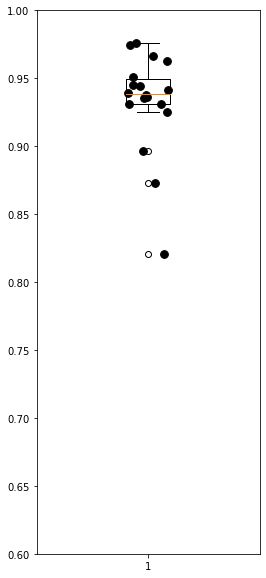

In [107]:
both_f1s = full_f1s[np.unique(np.concatenate([ytrue_Ids_topN,yhat_Ids_topN],axis=0))]
plt.figure(figsize = (4,10))


plt.boxplot(both_f1s,widths = 0.2)
plt.ylim([0.6,1.0])
plt.scatter(x=np.random.uniform(low=0.9,high=1.1,size=len(both_f1s)),y=both_f1s, c='black',s=60)
plt.savefig('./figures/bar_hatplustrue.pdf')

In [ ]:
plt.figure(figsize = (10,8))
df_x = pd.read_csv('./X_m9.csv',index_col=0)
ax = sns.heatmap(X,cmap="YlGnBu",yticklabels=[],xticklabels=df_x.columns)
plt.xticks(rotation=45) 
plt.savefig('./figures/heat_X.pdf')

plt.figure(figsize = (10,8))
cmap=cm.get_cmap("YlOrRd",200)
df_y = pd.read_csv('./X_c13.csv',index_col=0)
# df_y=df_y.drop(['Mitomycin'], axis=1)
df_y['mean'] = df_y.mean(axis=1)
ax = sns.heatmap(df_y,cmap=cmap,yticklabels=[],xticklabels=df_y.columns)
plt.xticks(rotation=45) 
plt.savefig('./figures/heat_y.pdf')


(13, 10)

(10, 10)

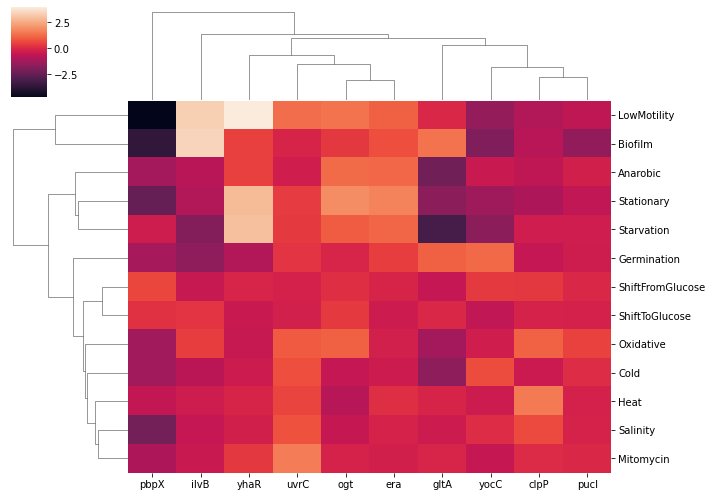

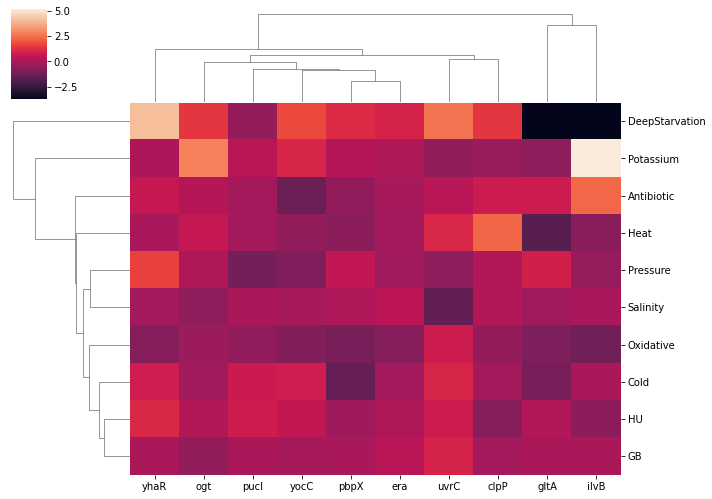

In [181]:
fd_int = pd.read_csv('./foldChanges_inter.csv',index_col=0).transpose()
fd_int.shape
hm = sns.clustermap(fd_int,figsize=(10,7))
intCond_reordered = fd_int.index[hm.dendrogram_row.reordered_ind].to_numpy()
intBiomarker_reordered = fd_int.columns[hm.dendrogram_col.reordered_ind].to_numpy()


fd_ext = pd.read_csv('./foldChanges_ext.csv',index_col=0).transpose()
fd_ext.shape
hm1 = sns.clustermap(fd_ext,figsize=(10,7))


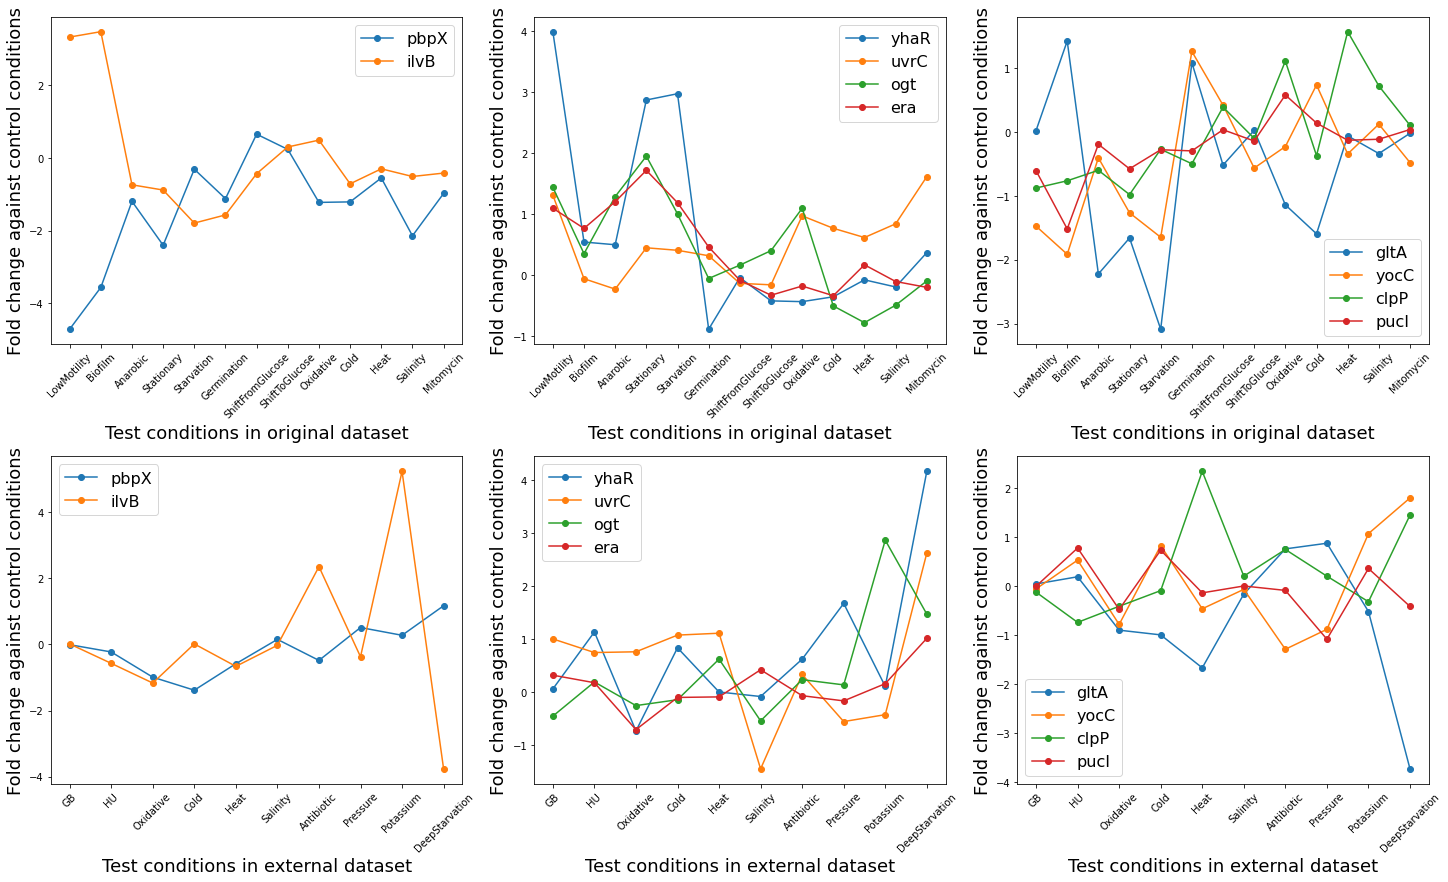

In [182]:
def ExpProfilePlot(axe,df,token):
    df.plot(style='o-',ax=axe)
    _ = axe.set_xlabel('Test conditions in '+token+' dataset',fontsize=18)
    _ = axe.set_ylabel('Fold change against control conditions', fontsize=18)
    _ = axe.set_xticks(range(len(df.index)))
    _ = axe.set_xticklabels(df.index,rotation=45)
    _ = axe.legend(fontsize=16)

f,a = plt.subplots(2,3,figsize=(20,12),constrained_layout=True)

a =a.ravel()
ExpProfilePlot(a[0],fd_int.loc[intCond_reordered,intBiomarker_reordered[:2]],'original')
ExpProfilePlot(a[1],fd_int.loc[intCond_reordered,intBiomarker_reordered[2:6]],'original')
ExpProfilePlot(a[2],fd_int.loc[intCond_reordered,intBiomarker_reordered[6:10]],'original')

extCond_reordered = ['GB','HU','Oxidative','Cold','Heat', 'Salinity', 'Antibiotic','Pressure', 'Potassium' , 'DeepStarvation']

ExpProfilePlot(a[3],fd_ext.loc[extCond_reordered,intBiomarker_reordered[:2]],'external')
ExpProfilePlot(a[4],fd_ext.loc[extCond_reordered,intBiomarker_reordered[2:6]],'external')
ExpProfilePlot(a[5],fd_ext.loc[extCond_reordered,intBiomarker_reordered[6:10]],'external')

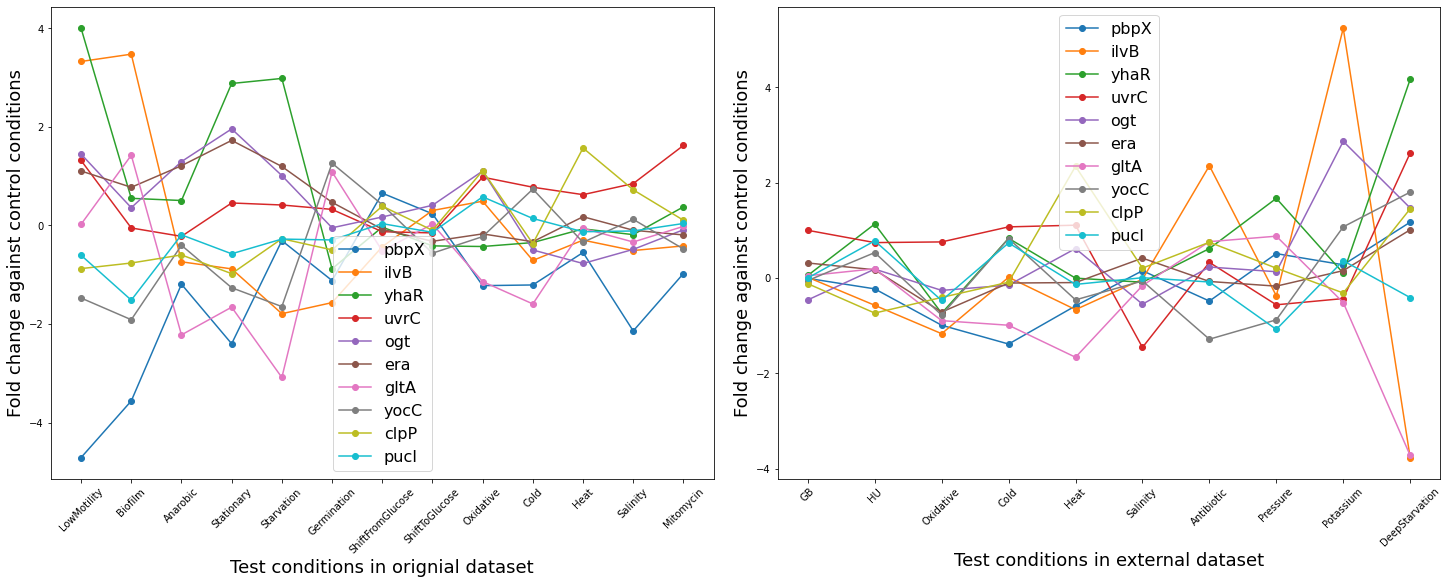

In [183]:
f,a = plt.subplots(1,2,figsize=(20,8),constrained_layout=True)
a = a.ravel()

ExpProfilePlot(a[0],fd_int.loc[intCond_reordered,intBiomarker_reordered],'orignial')


ExpProfilePlot(a[1],fd_ext.loc[extCond_reordered,intBiomarker_reordered],'external')

plt.savefig('./figures/ExpProLines.pdf')






,SepalLength,SepalWidth,PetalLength,PetalWidth,Name
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


<AxesSubplot:>

,pbpX,ilvB,yhaR,uvrC,ogt,era,gltA,yocC,clpP,pucI
LowMotility,-4.711226,3.322968,3.996675,1.315677,1.444094,1.101833,0.021076,-1.474894,-0.878283,-0.607396
Biofilm,-3.562732,3.471054,0.547252,-0.054032,0.357157,0.771048,1.421463,-1.914785,-0.764890,-1.517797
Anarobic,-1.194820,-0.740385,0.503017,-0.224427,1.292193,1.208521,-2.222699,-0.405556,-0.600803,-0.193688
Stationary,-2.402068,-0.884072,2.876392,0.452973,1.955174,1.722387,-1.660391,-1.266149,-0.980449,-0.577709
Starvation,-0.311509,-1.792763,2.979143,0.412048,1.008946,1.192847,-3.086920,-1.648560,-0.272029,-0.279351
Germination,-1.120568,-1.568325,-0.881771,0.322601,-0.050498,0.466170,1.083010,1.259046,-0.498359,-0.297103
ShiftFromGlucose,0.651983,-0.434589,-0.036465,-0.129824,0.168347,-0.079775,-0.519094,0.417959,0.388005,0.033784
ShiftToGlucose,0.233715,0.300305,-0.417424,-0.154316,0.405912,-0.324644,0.024399,-0.565535,-0.101339,-0.142669
Oxidative,-1.224086,0.488701,-0.430095,0.976885,1.100631,-0.174093,-1.141610,-0.229412,1.107827,0.577741
Cold,-1.210108,-0.712812,-0.350164,0.772536,-0.500523,-0.332684,-1.594638,0.734044,-0.371105,0.138074


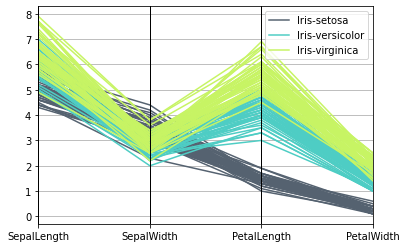

In [187]:
df = pd.read_csv(
    'https://raw.github.com/pandas-dev/'
    'pandas/master/pandas/tests/io/data/csv/iris.csv'
)
df
pd.plotting.parallel_coordinates(df, 'Name', color=('#556270', '#4ECDC4', '#C7F464'))
fd_int.loc[intCond_reordered,intBiomarker_reordered]
# pd.plotting.parallel_coordinates(fd_int.loc[intCond_reordered,intBiomarker_reordered], 'Name', color=('#556270', '#4ECDC4', '#C7F464'))

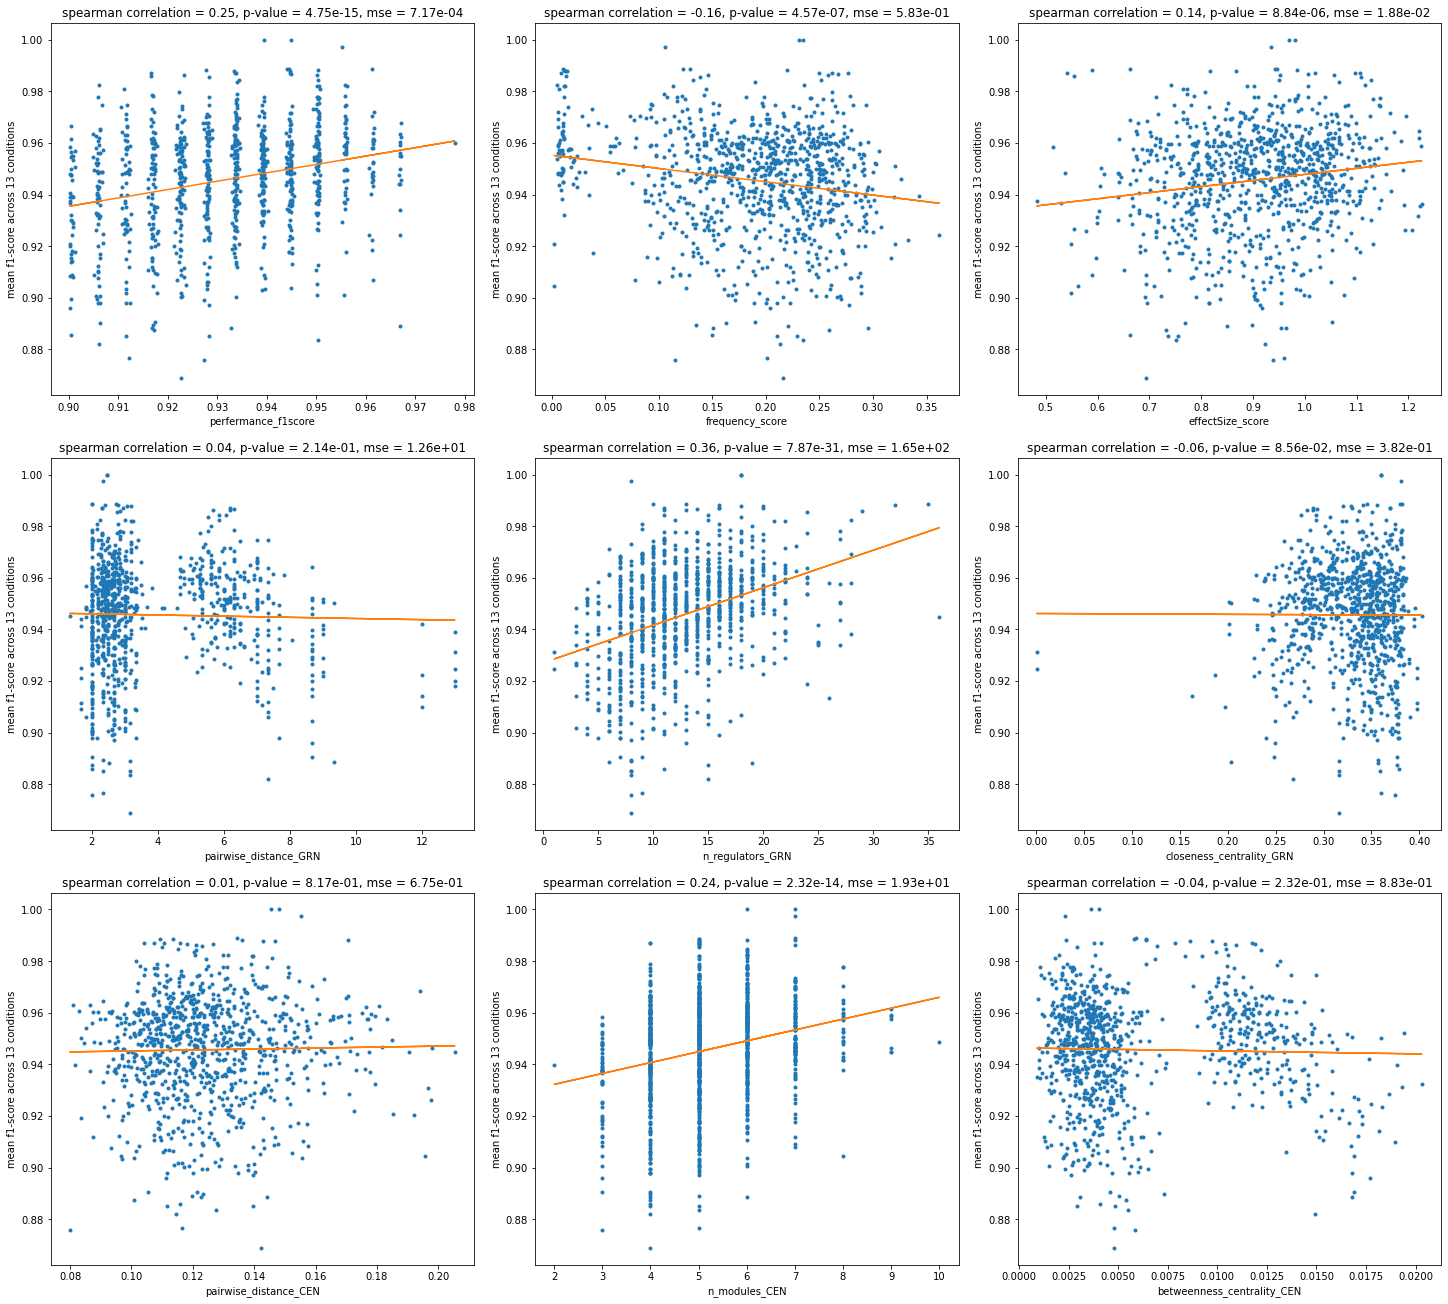

In [233]:
def my_statistic(x, y):
    return stats.spearmanr(x,y)[0]

def bootstrap(x,y, n=1000, func=my_statistic):
    """
    Generate `n` bootstrap samples, evaluating `func`
    at each resampling. `bootstrap` returns a function,
    which can be called to obtain confidence intervals
    of interest.
    """
    simulations = list()
    sample_size = len(x)
    for c in range(n):
        itersample = np.random.choice(range(sample_size), size=sample_size, replace=True)
        itersampleX = x[itersample]
        itersampleY = y[itersample]
        simulations.append(func(itersampleX,itersampleY))
    simulations.sort()
    def ci(p):
        """
        Return 2-sided symmetric confidence interval specified
        by p.
        """
        u_pval = (1+p)/2.
        l_pval = (1-u_pval)
        l_indx = int(np.floor(n*l_pval))
        u_indx = int(np.floor(n*u_pval))
        return(simulations[l_indx],simulations[u_indx])
    return(ci)

scaler = StandardScaler()
df_x = pd.read_csv('./X_m9.csv',index_col=0)
X = df_x.to_numpy()
# X = scaler.fit_transform(X)
metric_names = pd.read_csv('./X_m9.csv',index_col=0).columns.to_numpy()   
y = pd.read_csv('./X_c13.csv',index_col=0).to_numpy()
y = np.mean(y,axis=1)

f,a = plt.subplots(3,3,figsize=(20,18),constrained_layout=True)
a = a.ravel()

rho_list = []
rhoLowInt_list = []
rhoHighInt_list = []
mse_list = []
pval_list = []

for idx,ax in enumerate(a):
    
    x_cur = X[:,idx]
    _ = ax.plot(x_cur,y,'.')
    b, m = polyfit(x_cur, y, 1)
    _ = ax.plot(x_cur, b + m * x_cur, '-')
    _ = ax.set_xlabel(metric_names[idx])
    _ = ax.set_ylabel('mean f1-score across 13 conditions')
    rho, pval = stats.spearmanr(x_cur,y)
    mse = mean_squared_error(x_cur,y)
    rho_list.append(rho)
    boot = bootstrap(x_cur,y, n=900,func=my_statistic)
    lowInt,highInt = boot(0.95)
    rhoLowInt_list.append(lowInt)
    rhoHighInt_list.append(highInt)
    mse_list.append(mse)
    pval_list.append(pval)

    _ = ax.set_title('spearman correlation = {:.2f}, p-value = {:.2e}, mse = {:.2e}'.format(rho,pval,mse))


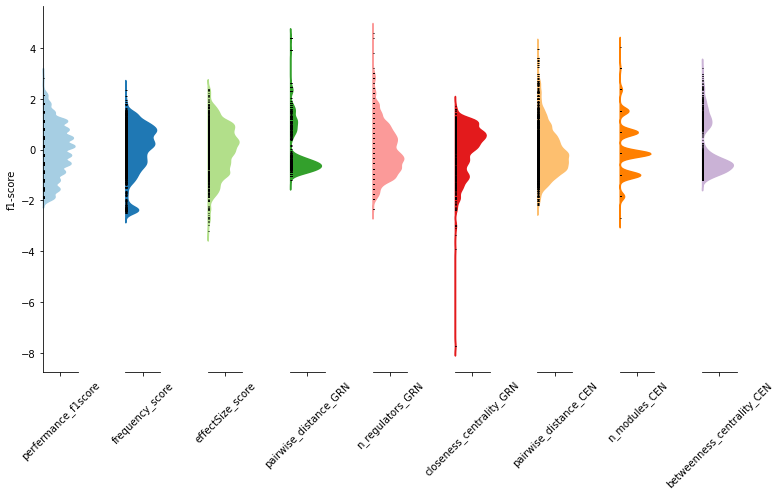

In [232]:
# from statsmodels.graphics.boxplots import violinplot
df_x = pd.read_csv('./X_m9.csv',index_col=0)
df_x = pd.DataFrame(scaler.fit_transform(df_x),index=df_x.index,columns=df_x.columns)
             
x_m9 = pd.DataFrame(df_x.stack())
x_m9 = x_m9.reset_index() 

x_m9=x_m9.set_index('PanelName')

x_m9.columns=['metric_names','f1-score']
col_dic = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
# violinplot(data=x_m9,ax=ax,labels=metric_names, side='left', show_boxplot=False, plot_opts={'violin_fc':col_dic})
# sns.kdeplot(data=x_m9,fill=True,  alpha=.5, linewidth=0)
fig = plt.figure(figsize=(20,12))
# sns.violinplot(data=x_m9, split=True, inner = 'quartile',palette="pastel", legend=False)
categorical_kde_plot(x_m9, variable="f1-score",category="metric_names",category_order=metric_names, horizontal=False,color=col_dic)



<AxesSubplot:xlabel='Density'>

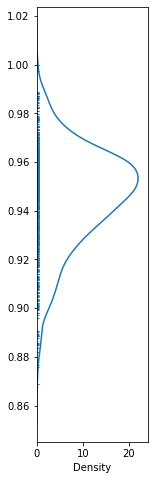

In [282]:
fig = plt.figure(figsize=(2,8))
sns.distplot(a=y_mean,hist=False, kde=True, rug=True,vertical=True)
plt.savefig('./figures/stressIndex.pdf')



In [231]:
def categorical_kde_plot(
    df,
    color,
    variable,
    category,
    category_order=None,
    horizontal=False,
    rug=True,
    figsize=None,
    
):
    """Draw a categorical KDE plot

    Parameters
    ----------
    df: pd.DataFrame
        The data to plot
    variable: str
        The column in the `df` to plot (continuous variable)
    category: str
        The column in the `df` to use for grouping (categorical variable)
    horizontal: bool
        If True, draw density plots horizontally. Otherwise, draw them
        vertically.
    rug: bool
        If True, add also a sns.rugplot.
    figsize: tuple or None
        If None, use default figsize of (7, 1*len(categories))
        If tuple, use that figsize. Given to plt.subplots as an argument.
    """
    if category_order is None:
        categories = list(df[category].unique())
    else:
        categories = category_order[:]

    figsize = (7, 1.2 * len(categories))

    fig, axes = plt.subplots(
        nrows=len(categories) if horizontal else 1,
        ncols=1 if horizontal else len(categories),
        figsize=figsize[::-1] if not horizontal else figsize,
        sharex=horizontal,
        sharey=not horizontal,
    )
    

    for i, (cat, ax) in enumerate(zip(categories, axes)):
        sns.kdeplot(
            data=df[df[category] == cat],
            x=variable if horizontal else None,
            y=None if horizontal else variable,
            # kde kwargs
            bw_adjust=0.5,
            clip_on=False,
            fill=True,
            alpha=1,
            linewidth=1.5,
            ax=ax,
            color=color[i],
        )
       
        _ = ax.set_xticklabels(labels=df[category],rotation=45)


        keep_variable_axis = (i == len(fig.axes) - 1) if horizontal else (i == 0)

        if rug:
            sns.rugplot(
                data=df[df[category] == cat],
                x=variable if horizontal else None,
                y=None if horizontal else variable,
                ax=ax,
                color="black",
                height=0.025 if keep_variable_axis else 0.04,
            )

        _format_axis(
            ax,
            cat,
            horizontal,
            keep_variable_axis=keep_variable_axis,
        )

    plt.tight_layout()
    
    plt.savefig('./figures/x_m9_dist.pdf')




def _format_axis(ax, category, horizontal=False, keep_variable_axis=True):

    # Remove the axis lines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    if horizontal:
        ax.set_ylabel(None)
        lim = ax.get_ylim()
        ax.set_yticks([(lim[0] + lim[1]) / 2])
        ax.set_yticklabels([category])
        if not keep_variable_axis:
            ax.get_xaxis().set_visible(False)
            ax.spines["bottom"].set_visible(False)
    else:
        ax.set_xlabel(None)
        lim = ax.get_xlim()
        ax.set_xticks([(lim[0] + lim[1]) / 2])
        ax.set_xticklabels([category])
        if not keep_variable_axis:
            ax.get_yaxis().set_visible(False)
            ax.spines["left"].set_visible(False)


if __name__ == "__main__":
    df = sns.load_dataset("tips")

array([[0.06329279, 0.05899685, 0.059161  , 0.06888796, 0.0559516 ,
        0.06308282, 0.06312567, 0.05288654, 0.06227456],
       [0.06114578, 0.06509385, 0.06110462, 0.06732449, 0.0566202 ,
        0.06184072, 0.06218019, 0.0545509 , 0.06611705]])

(<Figure size 864x288 with 1 Axes>, <AxesSubplot:>)

[0.25054237521173406,
 -0.16284514053676274,
 0.14369192793927005,
 0.04039292655312287,
 0.3624123746034307,
 -0.05582721148791899,
 0.007500963951729498,
 0.24428234637735016,
 -0.038821111390997184]

<ErrorbarContainer object of 3 artists>

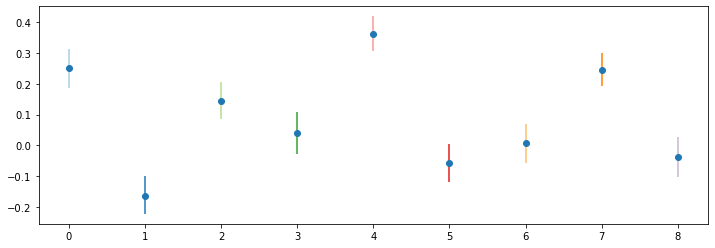

In [248]:
yerr = np.array([np.array(rho_list)-np.array(rhoLowInt_list),np.array(rhoHighInt_list)-np.array(rho_list)])
yerr
plt.subplots(figsize=(12,4))
rho_list
plt.errorbar(x=range(9),y=np.array(rho_list),yerr=yerr, fmt='o',ecolor=col_dic)
plt.savefig('./figures/rho_m9Y.pdf')



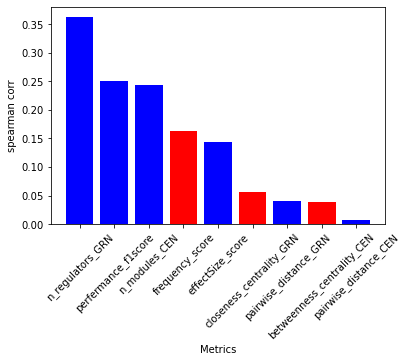

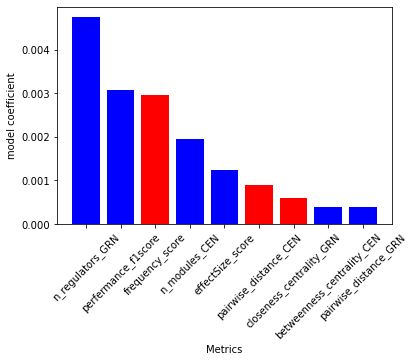

In [260]:
idx_sort = np.argsort(np.abs(rho_list))[::-1]

spear_corr = np.array(rho_list)[idx_sort]
_ = plt.bar(metric_names[idx_sort],np.abs(spear_corr),color=['blue' if weight>0 else 'red' for weight in spear_corr])
_ = plt.xlabel('Metrics')
_ = plt.xticks(rotation=45)
_ = plt.ylabel('spearman corr')
_ =plt.show()

idx_sort = np.argsort(np.abs(regr_full.coef_))[::-1]
regr_coeff = np.array(regr_full.coef_)[idx_sort]
_ = plt.bar(metric_names[idx_sort],np.abs(regr_coeff),color=['blue' if weight>0 else 'red' for weight in regr_coeff])
_ = plt.xlabel('Metrics')
_ = plt.xticks(rotation=45)
_ = plt.ylabel('model coefficient')
_ =plt.show()

In [195]:
from sklearn.feature_selection import RFE



df_pressure =  np.transpose(pd.read_csv('valdata/pressure_new.csv',index_col=0))
sample_ID = df_pressure.index.to_numpy()
gene_names= df_pressure.columns.to_numpy()
[n_genes,n_samples] = df_pressure.shape
[n_genes,n_samples] 
sample_ID

label = [0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1]
label

df_pressure

[16, 4421]

array(['P0_B1', 'P0_B2', 'P0_B3', 'P0_B4', 'P0_T1', 'P200_B1', 'P200_B2',
       'P200_B3', 'P200_B4', 'P200_T1', 'P200_T2', 'P400_B1', 'P400_B2',
       'P400_B3', 'P400_B4', 'P400_T1'], dtype=object)

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

,dnaA,dnaN,rlbA,recF,remB,gyrB,gyrA,trnO-Ile,rrnO-23S,rrnO-5S,...,parA,yyaB,nocA,rsmG,trmF,mnmE,jag,oxaAA,rnpA,rpmH
P0_B1,8.168765,7.044133,6.676535,8.239248,6.247565,8.170619,8.487826,0.000000,1.420710,1.743525,...,8.717488,5.729451,8.447017,6.499819,7.279937,7.455666,9.394952,8.933505,7.538781,11.808025
P0_B2,8.063374,7.055682,6.748761,8.287810,6.113198,8.257360,8.585227,0.000000,3.332786,1.223763,...,8.608812,5.115205,8.444946,6.640995,7.385205,7.549873,9.361976,8.931165,7.396893,11.773941
P0_B3,8.388439,7.168711,6.723200,8.456319,6.472754,8.440839,8.612706,0.000000,4.446263,1.294130,...,8.852446,5.716236,8.456770,6.909288,7.587937,7.659644,9.694182,9.295022,7.720067,11.168495
P0_B4,8.338211,7.227105,6.810057,8.455141,6.531963,8.372142,8.500335,0.000000,4.571675,1.797765,...,8.744289,5.733295,8.444140,6.731833,7.376844,7.477240,9.617758,9.248178,7.640917,11.390293
P0_T1,8.482242,7.366547,6.696884,8.473526,6.515768,8.439027,8.468393,0.000000,2.882271,1.886923,...,8.767381,5.730736,8.320707,6.389841,7.268421,7.336833,9.807639,9.464477,7.851344,11.334765
P200_B1,8.271063,7.245650,6.537039,8.257421,6.272206,8.502837,8.781012,0.000000,2.364757,1.067086,...,8.939998,4.981272,8.398049,6.969876,7.532000,7.508885,9.426437,8.983767,7.158245,10.647711
P200_B2,8.231053,7.257902,6.405183,7.855708,6.249357,8.266762,8.458620,0.433664,4.781507,1.605056,...,8.523665,5.079689,8.241135,5.393217,6.873383,6.959993,9.462979,8.978512,7.169966,11.196152
P200_B3,8.109934,7.231771,6.564755,7.761468,6.356664,8.134939,8.274039,0.000000,1.438534,2.117742,...,8.403193,4.827807,8.205495,5.934837,6.947476,6.849111,9.257205,8.780844,7.155340,11.259980
P200_B4,8.064342,7.150858,6.487046,7.835866,6.322977,8.276328,8.435678,0.000000,2.093158,1.968673,...,8.532116,4.793663,8.240445,5.275300,6.798815,6.885393,9.278646,8.803083,7.099867,11.256323
P200_T1,7.940196,7.113620,6.385835,7.809246,6.120439,8.200610,8.580482,0.000000,2.519890,0.666279,...,8.604907,5.297571,8.496959,6.665425,7.248885,7.141399,9.127761,8.595513,6.727565,11.405529


In [196]:


min_feature_size = 2
classifier = svm.SVC(kernel='linear', probability=True,class_weight='balanced')
y = label
X = df_pressure

selector = RFE(classifier, n_features_to_select=min_feature_size, step=2)
selector = selector.fit(X,y)


# with open ( output_path+"/panel.txt", "wt") as output:
#     for gene in gene_names[selector.support_]:
#         output.write('%s\n' % gene)

# output.close()

# with open (output_path+ "/ranking.txt", "wt") as output:
#     for ranking in selector.ranking_:
#         output.write('%s\n' % ranking)

# output.close()

In [214]:
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut

selector.ranking_
selector.support_
panel=gene_names[selector.ranking_<6]
X = df_pressure.iloc[:,selector.ranking_==1]

np.mean(cross_val_score(classifier, X, y, cv=LeaveOneOut(),scoring='f1_micro'))

array([1807, 1380, 1223, ...,  853,  495, 1956])

array([False, False, False, ..., False, False, False])

1.0

In [222]:
for i in range(1,20):
    gene_names[selector.ranking_==i]

array(['pftB', 'pftA'], dtype=object)

array(['dhbC'], dtype=object)

array(['sboX', 'yybF'], dtype=object)

array(['lctE', 'lctP'], dtype=object)

array(['narH', 'arfM'], dtype=object)

array(['rpsNB', 'besA'], dtype=object)

array(['putB', 'sboA'], dtype=object)

array(['hmpA', 'narG'], dtype=object)

array(['putC', 'cydB'], dtype=object)

array(['dhbA', 'albB'], dtype=object)

array(['narJ', 'narK'], dtype=object)

array(['oppA', 'yneN'], dtype=object)

array(['nirC', 'cydA'], dtype=object)

array(['katA', 'citB'], dtype=object)

array(['ykzH', 'cydC'], dtype=object)

array(['ylbP', 'albA'], dtype=object)

array(['alsS', 'cidA'], dtype=object)

array(['fldP', 'dhbB'], dtype=object)

array(['ypuA', 'yrhH'], dtype=object)

In [203]:
from sklearn.feature_selection import RFECV

selector1 = RFECV(classifier, n_features_to_select=, step=2)



Help on class RFECV in module sklearn.feature_selection._rfe:

class RFECV(RFE)
 |  RFECV(estimator, *, step=1, min_features_to_select=1, cv=None, scoring=None, verbose=0, n_jobs=None, importance_getter='auto')
 |  
 |  Recursive feature elimination with cross-validation to select the number of features.
 |  
 |  See glossary entry for :term:`cross-validation estimator`.
 |  
 |  Read more in the :ref:`User Guide <rfe>`.
 |  
 |  Parameters
 |  ----------
 |  estimator : ``Estimator`` instance
 |      A supervised learning estimator with a ``fit`` method that provides
 |      information about feature importance either through a ``coef_``
 |      attribute or through a ``feature_importances_`` attribute.
 |  
 |  step : int or float, default=1
 |      If greater than or equal to 1, then ``step`` corresponds to the
 |      (integer) number of features to remove at each iteration.
 |      If within (0.0, 1.0), then ``step`` corresponds to the percentage
 |      (rounded down) of features

SVC(class_weight='balanced', kernel='linear', probability=True)

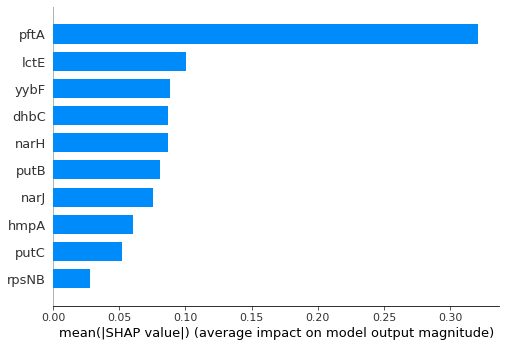

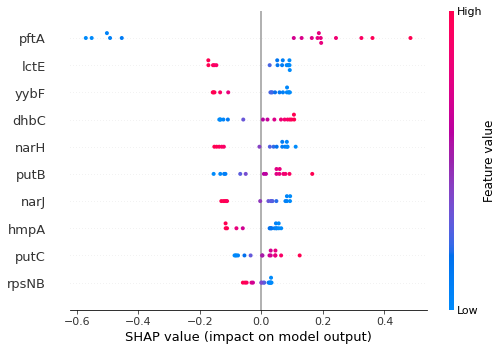

1.0

In [223]:
import shap
panel = ['pftA','dhbC','yybF','lctE','narH','rpsNB','putB','hmpA','putC','narJ']
# panel = ["yhaR","ogt","pbpX", "gltA", "yocC", "era", "ilvB", "uvrC", "clpP", "pucI"]
X = df_pressure.loc[:,panel]
classifier.fit(X,y)
shap_linear = shap.explainers.Linear(classifier, X)
shap_values = shap_linear.shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")
f = plt.figure()

shap.summary_plot(shap_values, X,plot_type='dot')
np.mean(cross_val_score(classifier, X, y, cv=LeaveOneOut(),scoring='f1_micro'))

KeyError: "None of [Index(['pftA', 'dhbC', 'yybF', 'lctE', 'narH', 'rpsNB', 'putB', 'hmpA', 'putC',\n       'narJ'],\n      dtype='object')] are in the [columns]"

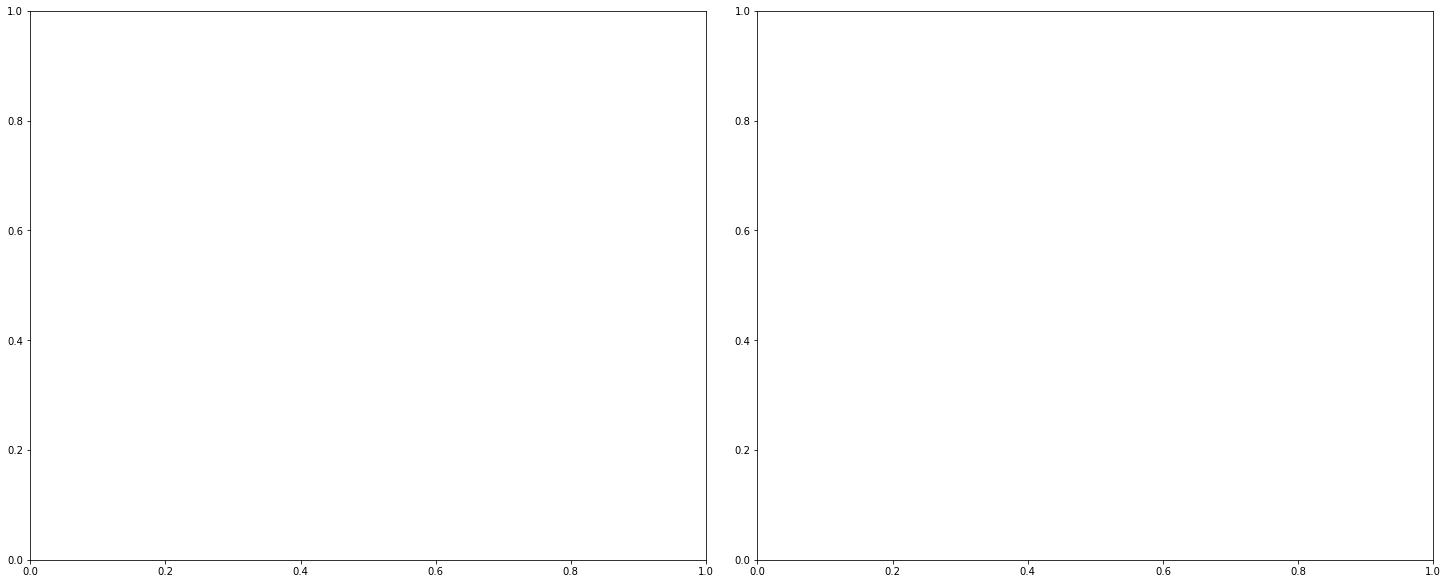

In [224]:
f,a = plt.subplots(1,2,figsize=(20,8),constrained_layout=True)
a = a.ravel()

ExpProfilePlot(a[0],fd_int.loc[intCond_reordered,panel],'orignial')


ExpProfilePlot(a[1],fd_ext.loc[extCond_reordered,panel],'external')



In [225]:
fd_int

,yhaR,ogt,pbpX,gltA,yocC,era,ilvB,uvrC,clpP,pucI
Stationary,2.876392,1.955174,-2.402068,-1.660391,-1.266149,1.722387,-0.884072,0.452973,-0.980449,-0.577709
Germination,-0.881771,-0.050498,-1.120568,1.083010,1.259046,0.466170,-1.568325,0.322601,-0.498359,-0.297103
LowMotility,3.996675,1.444094,-4.711226,0.021076,-1.474894,1.101833,3.322968,1.315677,-0.878283,-0.607396
Biofilm,0.547252,0.357157,-3.562732,1.421463,-1.914785,0.771048,3.471054,-0.054032,-0.764890,-1.517797
Anarobic,0.503017,1.292193,-1.194820,-2.222699,-0.405556,1.208521,-0.740385,-0.224427,-0.600803,-0.193688
Starvation,2.979143,1.008946,-0.311509,-3.086920,-1.648560,1.192847,-1.792763,0.412048,-0.272029,-0.279351
Heat,-0.072640,-0.774647,-0.551472,-0.061381,-0.345103,0.173980,-0.300781,0.621579,1.567927,-0.130822
Cold,-0.350164,-0.500523,-1.210108,-1.594638,0.734044,-0.332684,-0.712812,0.772536,-0.371105,0.138074
Salinity,-0.189180,-0.488449,-2.142788,-0.338938,0.120775,-0.099715,-0.511562,0.846072,0.719371,-0.114993
Oxidative,-0.430095,1.100631,-1.224086,-1.141610,-0.229412,-0.174093,0.488701,0.976885,1.107827,0.577741
